## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines center_very_broad, trained on a patch that covers most interesting $phi$ features, and glances the neighborhood of the peak.

Let's load the python modules and the model, first.

In [2]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'center_very_broad'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB

[0.01, 5, 2048, 0.0001, 50000, 1.0, 0.5, 0.2, 0.2]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

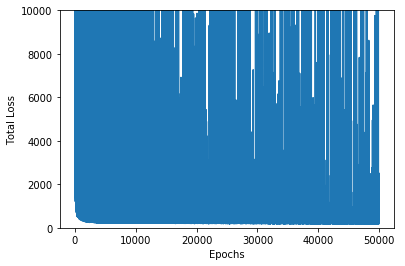

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 10000])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

The neighborhood of the peak provides many unpleasant peaks, although the loss in most cases seems to have plateaued around

In [3]:
print(L[-10:])

[236.343505859375, 228.40328979492188, 228.8177490234375, 241.40911865234375, 262.136474609375, 306.7627258300781, 252.56661987304688, 227.0801544189453, 254.11444091796875, 229.86807250976562]


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

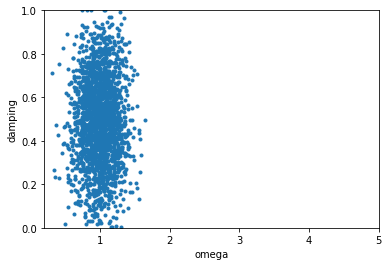

In [12]:
data, groundTruth = datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("omega")
plt.ylabel("damping")
plt.ylim([0, 1])
plt.xlim([0.2, 5.0])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [13]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [7]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[-0.01703432 -0.02004945]
 [ 0.00266937 -0.01423672]
 [-0.02599246  0.00762027]
 ...
 [-0.02669136 -0.03080505]
 [-0.00366545 -0.00018538]
 [ 0.00079659 -0.02739068]]


In [8]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.01681547976120964
Typical Amp Error
0.07029706506433096
Typical phase error / phase range
0.005419161208479759
Typical amp error / amp range
0.0061105232621939225


[0.02215042 0.01381109 0.01223242 ... 0.02349159 0.00018237 0.02645206]
0.027131857172636144
0.4544872138553285


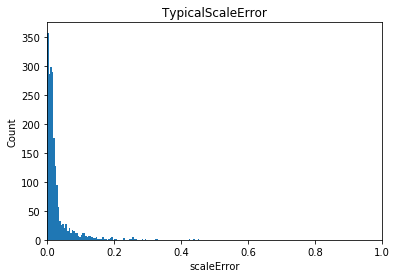

In [32]:
scaleError = abs(ampE)/amps
print(scaleError)
print(np.mean(scaleError))
print(max(scaleError))
fig = plt.figure()
plt.hist(scaleError, 100)
plt.xlim([0, 1])
plt.xlabel("scaleError")
plt.ylabel("Count")
plt.title("TypicalScaleError")
fig

So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $), as well as a distribution of the errors.

In [4]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


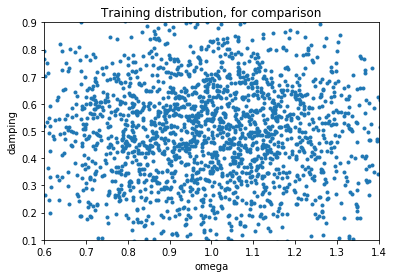

In [13]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [5]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [6]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

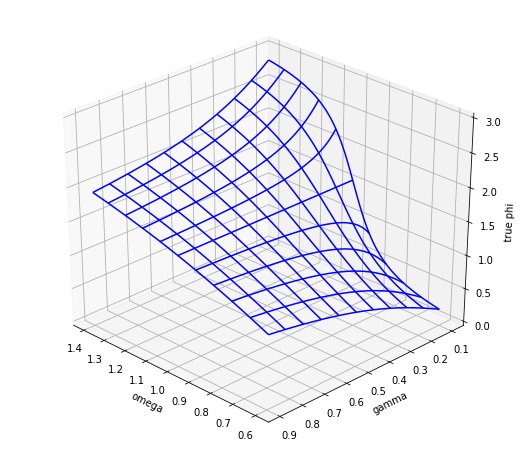

In [8]:
# Plot Phi, true and modeled

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
#surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")
ax.set_zlim(0,3)

fig

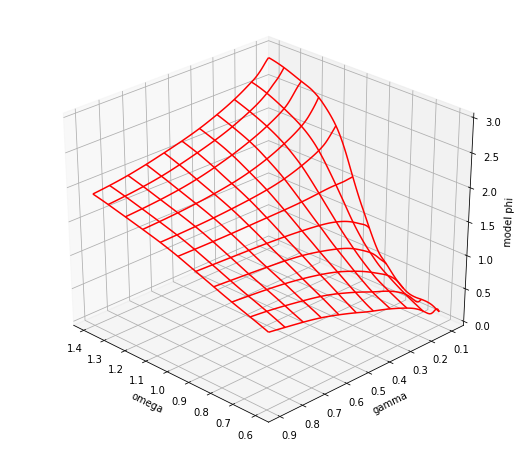

In [9]:
# Plot Phi, true and modeled

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("model phi")
ax.set_zlim(0,3)

fig

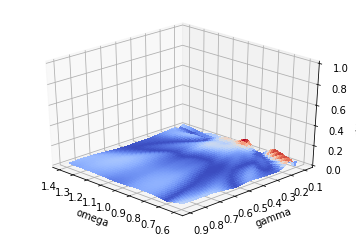

In [18]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

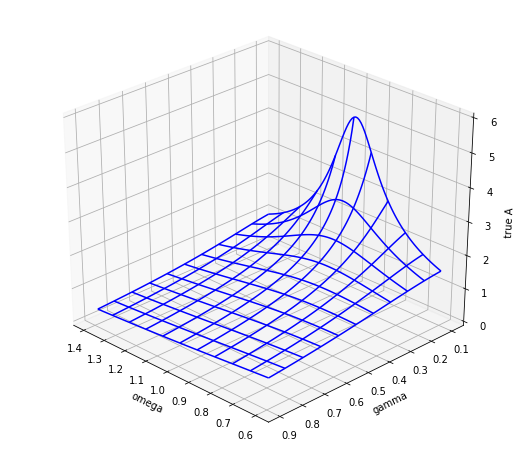

In [10]:
# Plot A

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
#surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim(0, 6)

fig

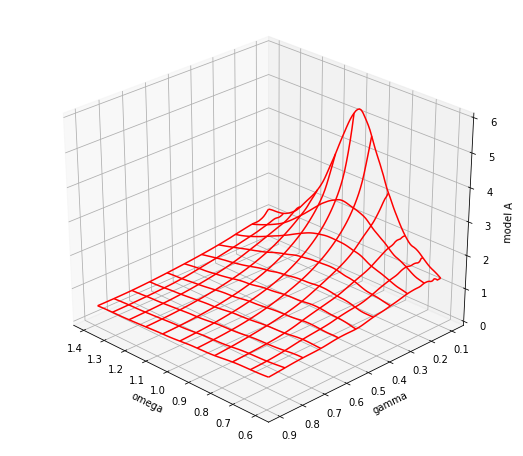

In [11]:
# Plot A

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("model A")
ax.set_zlim(0, 6)

fig

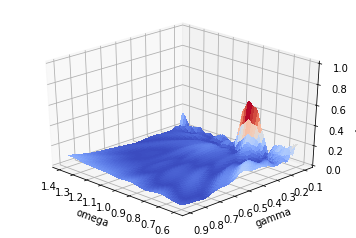

In [20]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

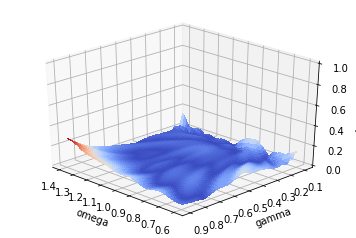

In [21]:
# Plot the L2 error / truth

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2)/A, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

In [23]:
# Make the data

wmin = 0.2
wmax = 1.8
wstep = (wmax - wmin)/100

bmin = 0.01
bmax = 1.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)
print(W.shape)

(101, 100)


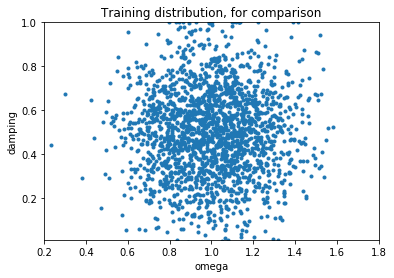

In [24]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [25]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [26]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10100, 1), B.reshape(10100, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(101, 100)
modelA = npo[:, 1].reshape(101, 100)

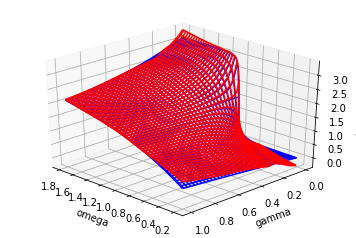

In [27]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")

fig

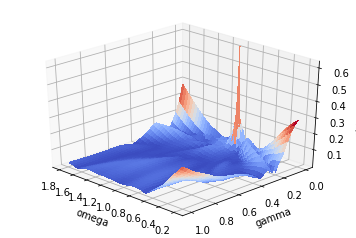

In [28]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

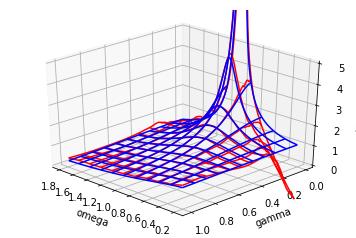

In [29]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim([0, 5])

fig

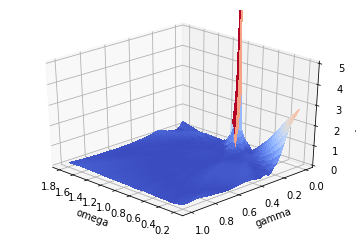

In [30]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 5])

fig

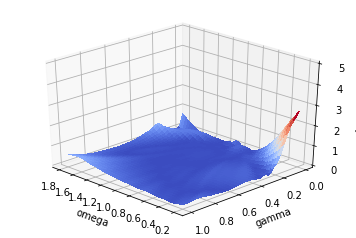

In [31]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2)/A, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [28]:
print("Max predicted phase")
print(max(modelPhi.reshape((10100,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10100,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10100,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10100,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10100,))))
print("Min true phase")
print(min(Phi.reshape((10100,))))
print("Max true amplitude")
print(max(A.reshape((10100,))))
print("Min true amplitude")
print(min(A.reshape((10100,))))

Max predicted phase
5.082669
Min predicted phase
-0.28107595
Max predicted amplitude
19.656815
Min predicted amplitude
-2.9780319



Max true phase
3.1373822065713624
Min true phase
0.004166642554263516
Max true amplitude
26.230985251581906
Min true amplitude
0.03918141559633489


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


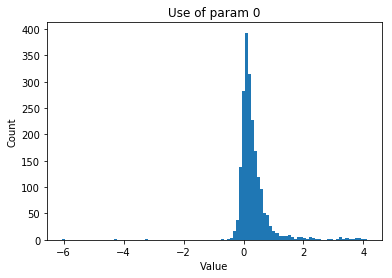

In [38]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


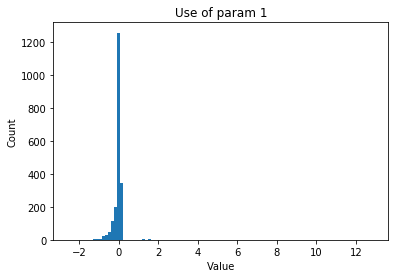

In [37]:
# Param 1 

fig = plt.figure()
plt.hist(means[:, 1], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


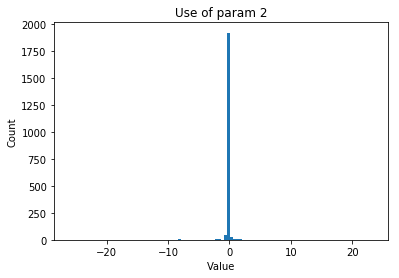

In [36]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

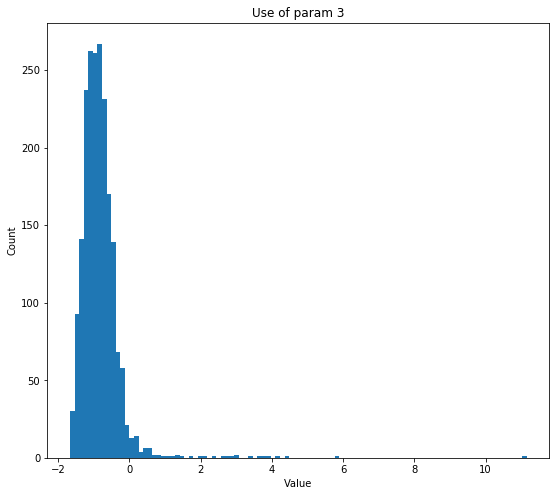

In [14]:
# Param 3

fig = plt.figure(figsize=(9, 8))
plt.hist(means[:, 3], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


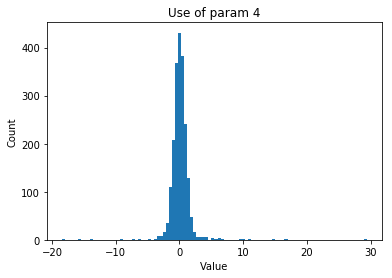

In [34]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
#plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, all parameters are used.

Let's plot their dependence on $\omega$ and $\gamma$ within the training distribution.

In [15]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [16]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param0 = npm[:, 0].reshape(100, 100)
param1 = npm[:, 1].reshape(100, 100)
param2 = npm[:, 2].reshape(100, 100)
param3 = npm[:, 3].reshape(100, 100)
param4 = npm[:, 4].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


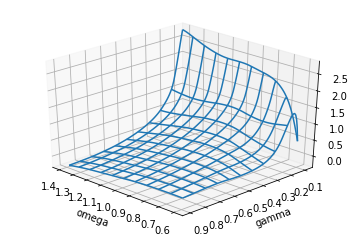

In [42]:
# Plot param 0

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param0, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param0")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


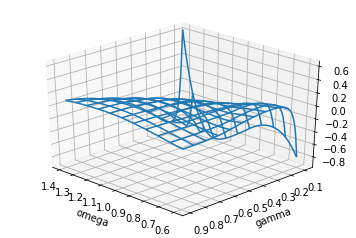

In [43]:
# Plot param 1

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param1, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param1")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


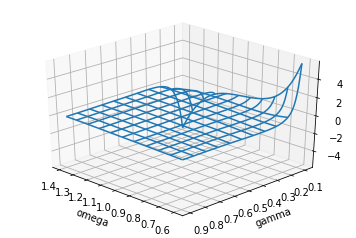

In [44]:
# Plot param 2

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param2, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param2")

fig

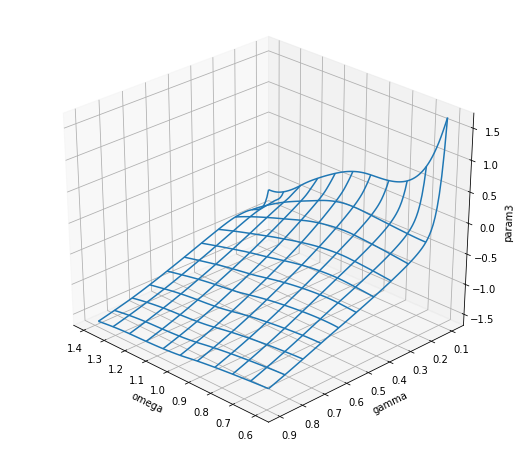

In [17]:
# Plot param 3

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param3, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


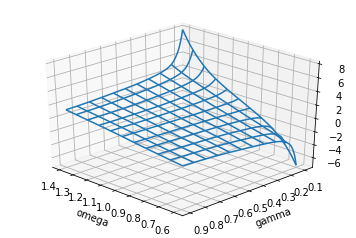

In [46]:
# Plot param 4

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param4, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

In [47]:
# Compute ground truth

Phi = phi(W, B)
A = amplitude(W, B)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


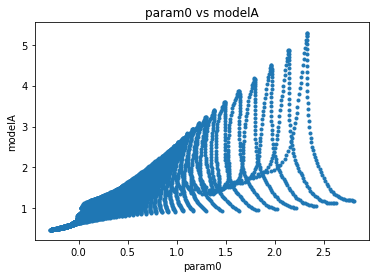

In [50]:
# Compare modelA and param0

fig = plt.figure()
plt.scatter(param0, modelA, marker='.')
plt.title("param0 vs modelA")
plt.xlabel("param0")
plt.ylabel("modelA")
fig

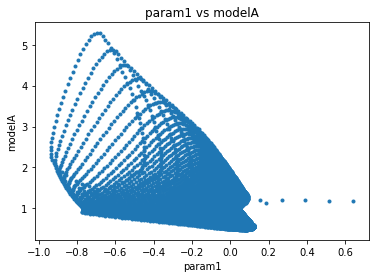

In [6]:
# Compare modelA and param1

fig = plt.figure()
plt.scatter(param1, modelA, marker='.')
plt.title("param1 vs modelA")
plt.xlabel("param1")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


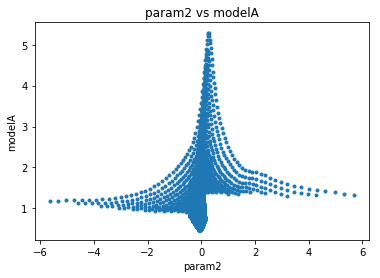

In [53]:
# Compare modelA and param2

fig = plt.figure()
plt.scatter(param2, modelA, marker='.')
plt.title("param2 vs modelA")
plt.xlabel("param2")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


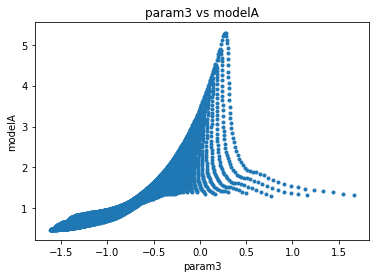

In [48]:
# Compare modelA and param3

fig = plt.figure()
plt.scatter(param3, modelA, marker='.')
plt.title("param3 vs modelA")
plt.xlabel("param3")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


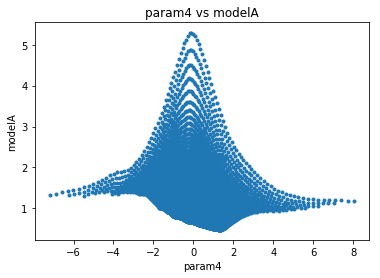

In [54]:
# Compare modelA and param4

fig = plt.figure()
plt.scatter(param4, modelA, marker='.')
plt.title("param4 vs modelA")
plt.xlabel("param4")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


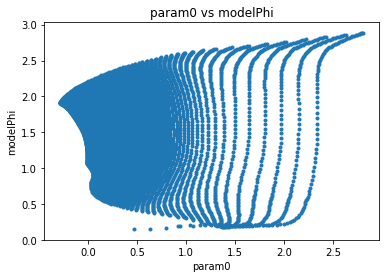

In [55]:
# Compare modelPhi and param0

fig = plt.figure()
plt.scatter(param0, modelPhi, marker='.')
plt.title("param0 vs modelPhi")
plt.xlabel("param0")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


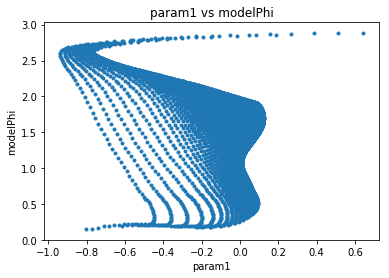

In [56]:
# Compare modelPhi and param1

fig = plt.figure()
plt.scatter(param1, modelPhi, marker='.')
plt.title("param1 vs modelPhi")
plt.xlabel("param1")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


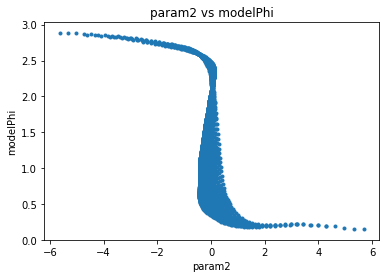

In [57]:
# Compare modelPhi and param2

fig = plt.figure()
plt.scatter(param2, modelPhi, marker='.')
plt.title("param2 vs modelPhi")
plt.xlabel("param2")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


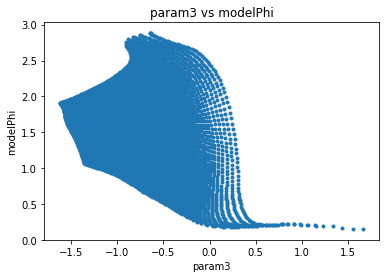

In [58]:
# Compare modelPhi and param3

fig = plt.figure()
plt.scatter(param3, modelPhi, marker='.')
plt.title("param3 vs modelPhi")
plt.xlabel("param3")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


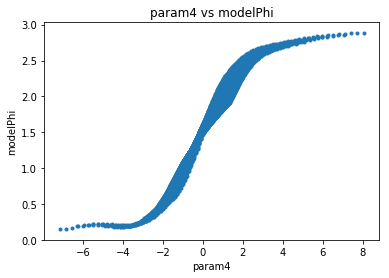

In [49]:
# Compare modelPhi and param4

fig = plt.figure()
plt.scatter(param4, modelPhi, marker='.')
plt.title("param4 vs modelPhi")
plt.xlabel("param4")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

This network performed more curiously than boring_patch. Within the range it was trained on, it very admirably captured all of the features, and had very low error. However, looking at the plot of $phi$ error, we begin to notice strange lines.

Once we try to use this network to extrapolate, these strange lines become bizzare artefacts; most unexpectedly, the "wing" on the $phi$ graph, extending towards infinity in low $\gamma$ and high $\omega$. It would seem that the sharp jump in $phi$ near resonance was difficult to model for the network, so it produced balanced multiple terms which balanced each other out in all portions of the training domain, but which failed to account for effects elsewhere - this behavior \emph{exactly} mimics artefacts we might expect from other smooth function interpolators, such as polynomials.

Examining the latent space reveals even more bizzare behavior. Firstly, it's worth noting that none of the parameter $\mu$s seem to be drawn from a univariate normal - clearly, $\beta$ was too low for the KL divergence term to have had much of an effect relative to the high variation in amplitude. To balance out this naive approach, I will run a model with $\beta$ scaled to the range of outputs.

Since there are 5 variables, but only $2$ outputs, its harder to figure out exactly which role the parameters play in producing the output - except maybe noting that param2 and param4 seem to determine the phase output. It's worth noting that many of the latent variables - param4, param2 and param1 - seem to act as some sort of "corner detector," which might explain the odd atefacts we see during extrapolation. 

What's certain, however, is that these parameters are not "natural, useful features" for the problem; they are at best analogous to the terms of a polynomial approximation, only harder to interpret.

But perhaps the data distribution we chose was still unnatural? What happens when we try to capture the behavior at the peak with the highest possible fidelity?